## Prepare for colab
Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [4]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"


CUDA version: 11.0


In [ ]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

In [ ]:
!pip install transformers==3.5.1
!pip install pymorphy2

In [ ]:
!git clone https://github.com/sberbank-ai/ru-clip.git

In [7]:
%load_ext autoreload

%autoreload 2

## Downloading the model

In [8]:
import sys
sys.path.append("ru-clip/")

In [11]:
from clip.evaluate.utils import (
    get_text_batch, get_image_batch, get_tokenizer,
    show_test_images, show_similarity,
    prepare_classes, call_model,
    show_topk_probs,
    load_weights_only,
    get_topk_accuracy,
    show_topk_accuracy
)
from clip.evaluate.tvd import get_text_probs_from_dataset
import torch
import json

In [12]:
model, args = load_weights_only("ViT-B/32-small")

100%|████████████████████████████████████████| 354M/354M [00:01<00:00, 187MiB/s]


In [13]:
model = model.cuda().float().eval()

In [14]:
import numpy as np
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Model parameters: 216,492,801


## Show similarity

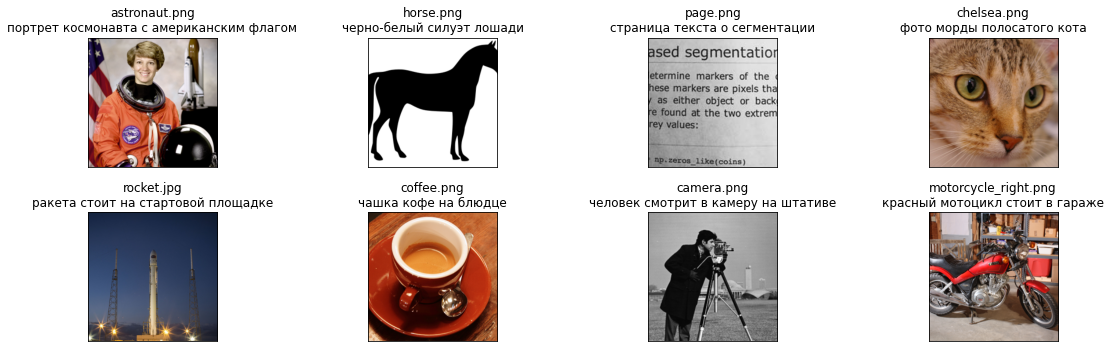

In [15]:
images, texts = show_test_images(args)

In [16]:
tokenizer = get_tokenizer()

### Building features

In [17]:
input_ids, attention_mask = get_text_batch(["Это " + desc for desc in texts], tokenizer, args)
img_input = get_image_batch(images, args.img_transform, args)

In [18]:
with torch.no_grad():
    logits_per_image, logits_per_text = model(
        img_input={"x": img_input},
        text_input={"x": input_ids, "attention_mask": attention_mask}
    )

### Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [19]:
similarity = logits_per_text.cpu().numpy() / 100

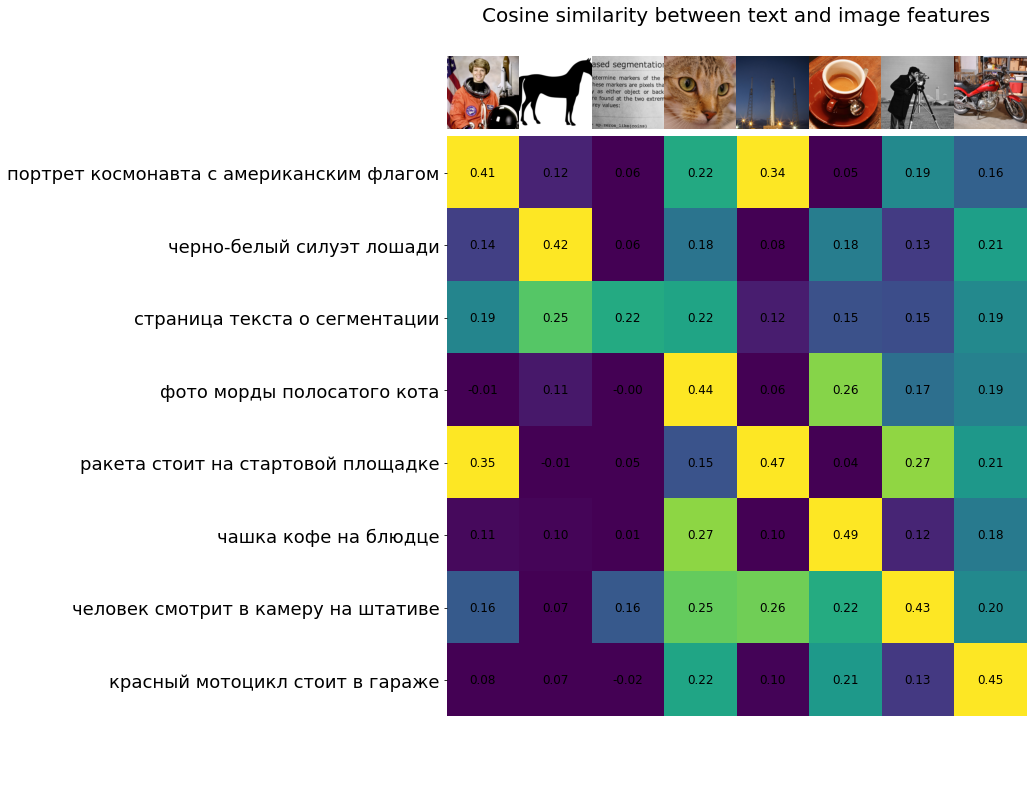

In [20]:
_ = show_similarity(images, texts, similarity, args)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [28]:
with open("ru-clip/clip/evaluate/classes.json", "r") as file:
    classes = json.load(file)

In [29]:
logits_per_image, logits_per_text = call_model(model, tokenizer, args, prepare_classes(classes), images)

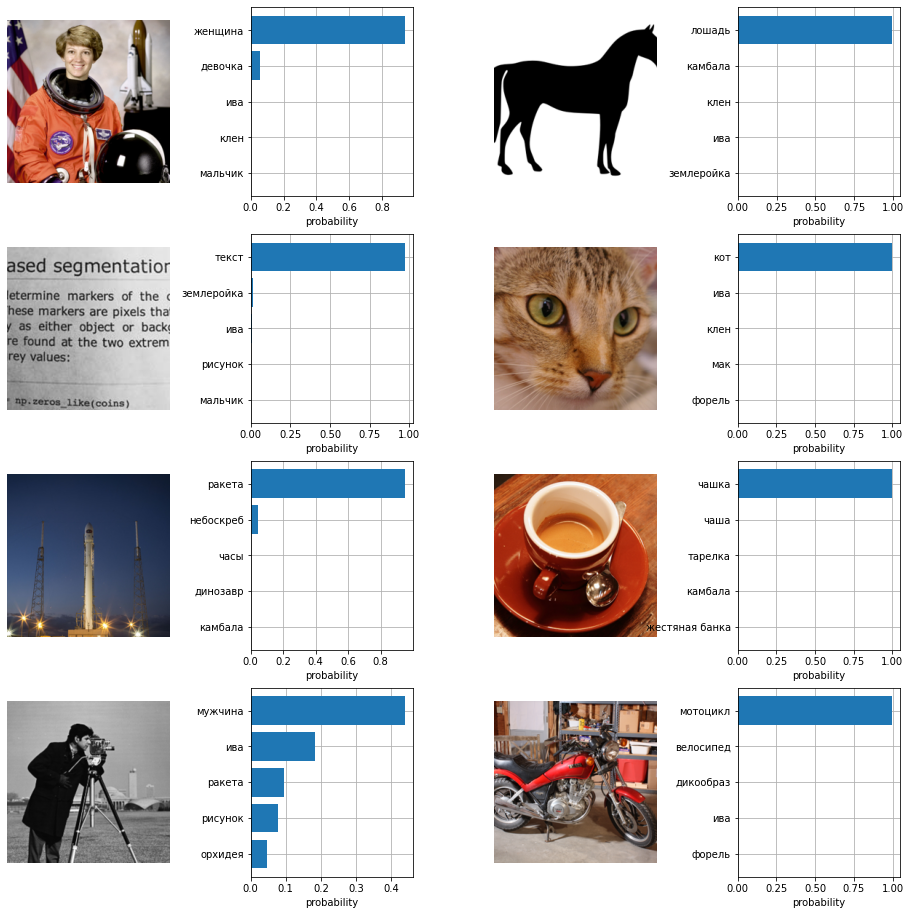

In [30]:
show_topk_probs(images, classes, logits_per_image, args, k=5)

## Evaluate CIFAR100

In [ ]:
probs, labels = get_text_probs_from_dataset(
    model, args, tokenizer, name="CIFAR100",
    classes_path="ru-clip/clip/evaluate/cifar100/cifar100classes.json"
)

In [34]:
with open("ru-clip/clip/evaluate/cifar100/cifar100classes.json", "r") as file:
    cifar100classes = json.load(file)

In [35]:
probs = np.array(probs)

#### Top-5 accuracy

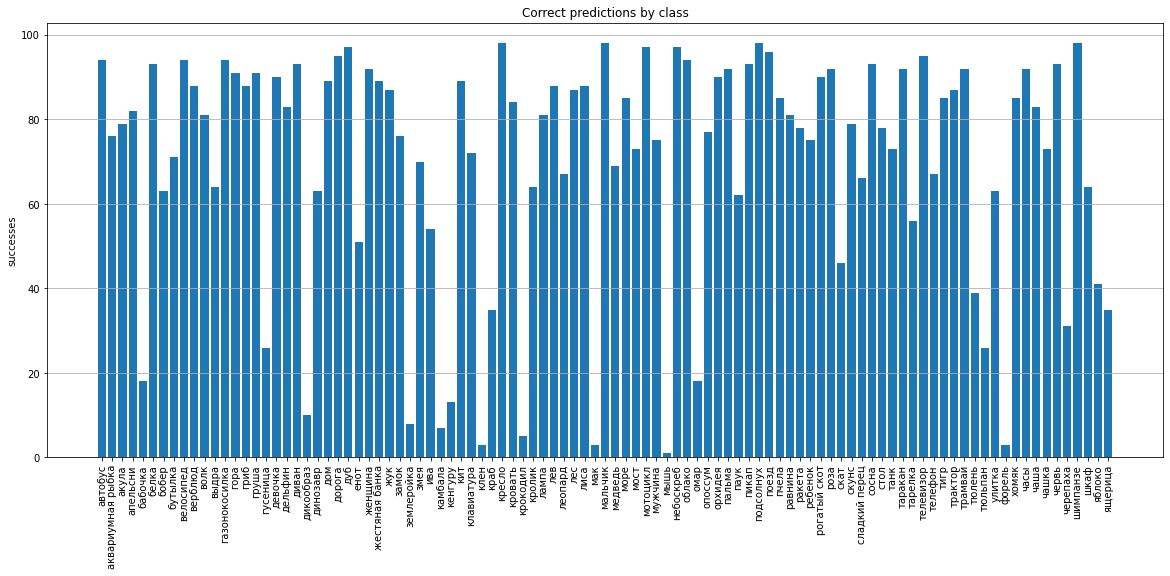

In [36]:
_ = show_topk_accuracy(labels, probs, cifar100classes, k=5)

In [37]:
get_topk_accuracy(labels, probs, 5)

0.6975

#### Top-1 accuracy

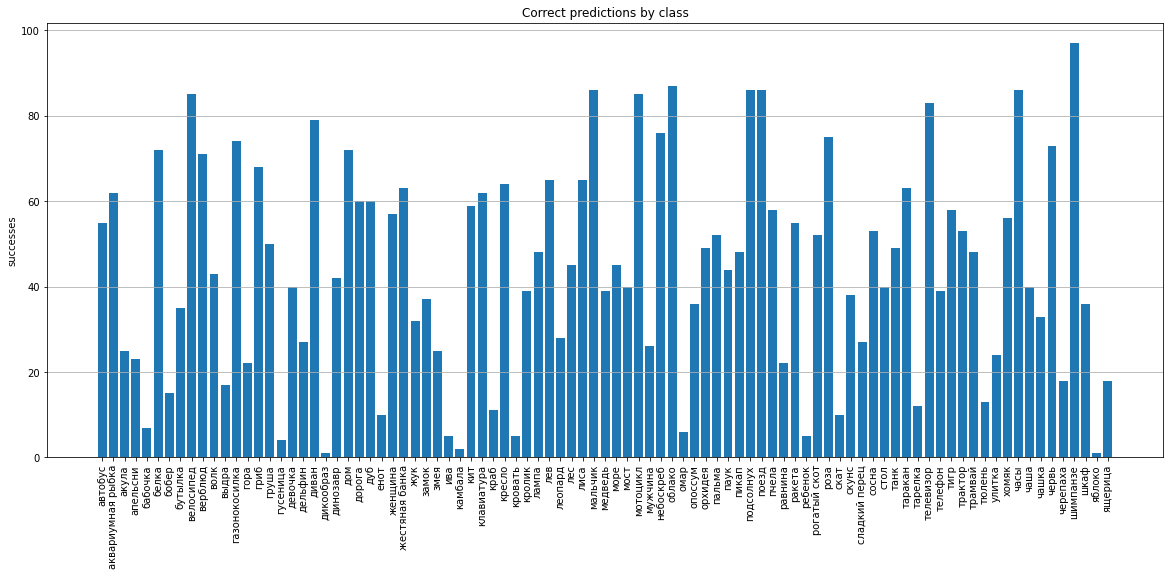

In [38]:
_ = show_topk_accuracy(labels, probs, cifar100classes, k=1)

In [39]:
get_topk_accuracy(labels, probs, 1)

0.4057

## Evaluate CIFAR10

In [ ]:
probs10, labels10 = get_text_probs_from_dataset(
    model, args, tokenizer, name="CIFAR10",
    classes_path="ru-clip/clip/evaluate/cifar10/cifar10classes.json"
)

In [42]:
with open("ru-clip/clip/evaluate/cifar10/cifar10classes.json", "r") as file:
    cifar10classes = json.load(file)

In [43]:
probs10 = np.array(probs10)

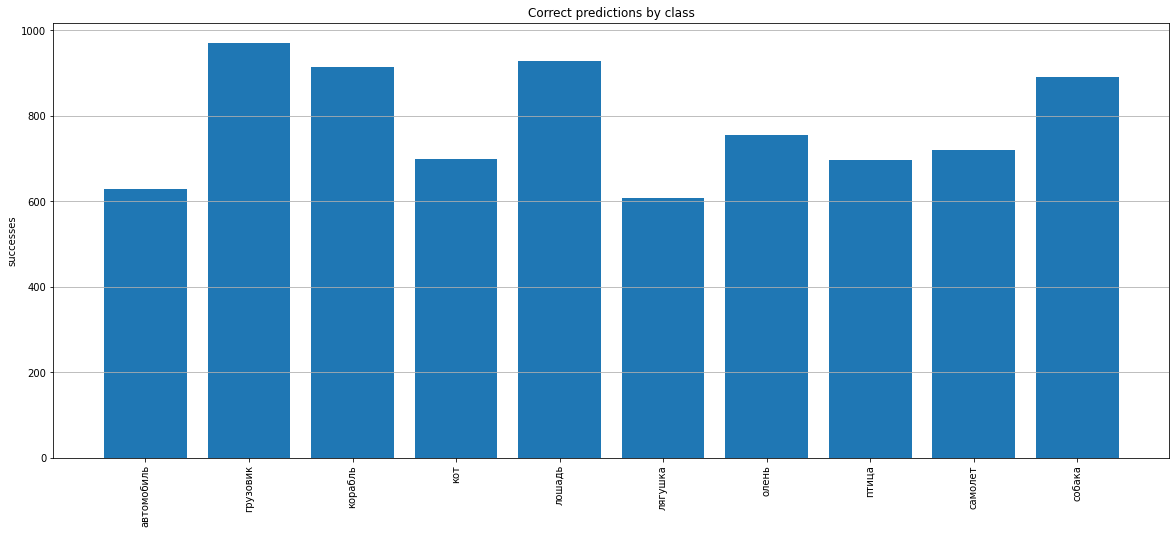

In [44]:
_ = show_topk_accuracy(labels10, probs10, cifar10classes, k=1)

In [45]:
get_topk_accuracy(labels10, probs10, 5)

0.9834

In [46]:
get_topk_accuracy(labels10, probs10, 1)

0.7803